Author: Vishal Jha
Email: jha.vishal2121@gmail.com

# Importing Libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from collections import Counter

# File Locations

In [2]:
file_location_news_data = '/Users/vishaljha/Documents/GitHub/ML Playground/FakeNewsDetector/Datasets/news.csv'

# Loading and processing Dataset

In [3]:
data = pd.read_csv(file_location_news_data)
data.shape

(6335, 4)

In [4]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
Counter(data['label'])

Counter({'FAKE': 3164, 'REAL': 3171})

In [6]:
data.isnull().count

<bound method DataFrame.count of       Unnamed: 0  title   text  label
0          False  False  False  False
1          False  False  False  False
2          False  False  False  False
3          False  False  False  False
4          False  False  False  False
...          ...    ...    ...    ...
6330       False  False  False  False
6331       False  False  False  False
6332       False  False  False  False
6333       False  False  False  False
6334       False  False  False  False

[6335 rows x 4 columns]>

## Label encoding the y data labels using LabelEncoder

In [7]:
lb = LabelEncoder()

data['label'] = lb.fit_transform(data['label'])

In [8]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


### CONCLUSION: The dataset contains 6335 unique news collections, out of which 3164 are FAKE and 3171 are REAL news. There are no null values.

# Creating test and train dataset

In [9]:
X = data['text']
y = data['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33)

In [11]:
X_train.shape, X_test.shape

((4244,), (2091,))

In [12]:
y_train

4903    0
6173    0
2430    1
5757    1
2028    0
       ..
3147    1
4866    1
20      1
2070    1
2535    1
Name: label, Length: 4244, dtype: int64

### CONCLUCION: Training dataset of 4244 rows and Testing dataset of 2091 rows is initialised

# Tokenisation of train and test datest labels as data processing, 
## and not removing stop words as to not affect the context of data and its formatting.

In [13]:
max_words = 2000
max_len = 400

token = Tokenizer(num_words=max_words, lower=True, split=' ')
token.fit_on_texts(X_train.values)

sequences = token.texts_to_sequences(X_train.values)
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)

In [14]:
train_sequences_padded

array([[   0,    0,    0, ...,   69, 1192,   21],
       [   0,    0,    0, ...,  114,  759,   69],
       [   0,    0,    0, ...,   24,   11,  141],
       ...,
       [ 457,   12,   15, ...,   23,   10,  571],
       [  68, 1405,   12, ...,  376,    9,   42],
       [  52,   18,  750, ...,  388, 1138,   21]], dtype=int32)

### CONCLUSION: Datset is tokenised without removing the stop words to preserve news context. Padded sequence is stored.

# BUILDING THE MODEL ARCHITECTURE
## Building an LSTM(long short-term memory) model as it is able to retain information for a long time.

In [15]:
embed_dims = 50
lstm_out = 64
batch_size = 32

In [16]:
model = Sequential()

model.add(Embedding(max_words, embed_dims, input_length= max_len))
model.add(LSTM(lstm_out))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, name= 'out_layer'))
model.add(Activation('sigmoid'))

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 50)           100000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

## MODEL TRAINING

In [18]:
model_history = model.fit(train_sequences_padded, y_train, batch_size= batch_size, epochs= 12, validation_split= 0.2)

Epoch 1/12
107/107 [==============================] - 12s 96ms/step - loss: 0.5998 - accuracy: 0.6728 - val_loss: 0.4686 - val_accuracy: 0.7856
Epoch 2/12
107/107 [==============================] - 10s 94ms/step - loss: 0.3392 - accuracy: 0.8666 - val_loss: 0.6834 - val_accuracy: 0.7703
Epoch 3/12
107/107 [==============================] - 10s 94ms/step - loss: 0.3890 - accuracy: 0.8277 - val_loss: 0.6873 - val_accuracy: 0.6890
Epoch 4/12
107/107 [==============================] - 10s 95ms/step - loss: 0.2536 - accuracy: 0.9037 - val_loss: 0.5458 - val_accuracy: 0.7797
Epoch 5/12
107/107 [==============================] - 10s 95ms/step - loss: 0.2181 - accuracy: 0.9134 - val_loss: 0.4803 - val_accuracy: 0.8127
Epoch 6/12
107/107 [==============================] - 10s 96ms/step - loss: 0.1489 - accuracy: 0.9452 - val_loss: 0.5000 - val_accuracy: 0.8233
Epoch 7/12
107/107 [==============================] - 10s 98ms/step - loss: 0.1396 - accuracy: 0.9473 - val_loss: 0.5383 - val_accuracy:

## MODEL EVALUATIONS

In [19]:
test_sequences = token.texts_to_sequences(X_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen= max_len)

model.evaluate(test_sequences_padded, y_test)

66/66 [==============================] - 2s 29ms/step - loss: 0.9296 - accuracy: 0.8245


[0.9296238422393799, 0.8244858980178833]

# MODEL ANALYSIS USING GRAPHS

([<matplotlib.axis.XTick at 0x7fba9b5d6e10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

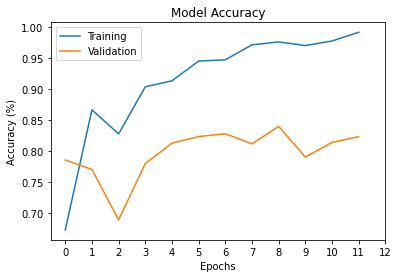

In [45]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')

plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])

([<matplotlib.axis.XTick at 0x7fba8f812610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

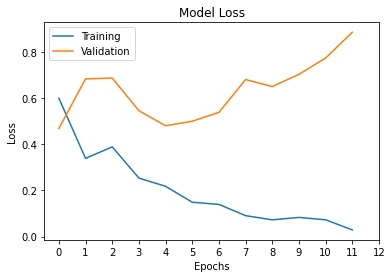

In [44]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])

### CONCLUSION: Loss and accuracy on training data is very good. Validation data hass very high loss index after and low accuracy after 6 epochs.

# SAVING THE MODEL

In [24]:
model.save('fake_news_detector.h5')

# MODEL TESTING ON REAL AND FAKE NEWS

## Importing a new fake and real news

In [40]:
fake = ["""

Most families of enormous wealth have a dark and sometimes scandalous, even monstrous past. Donald Trump's clan is no exception to that rule. His grandfather was a pimp and a tax evader, his father a racist who would in the course of his life, clash with New York City Police as a member of the Ku Klux Klan and then as a wealthy real estate magnate, refuse to rent to people of color.

Donald Trump's legacy is anything but a rag to riches story. His dad kicked the bucket with $250-$300 million in the bank. The man who wants to ban all people of a particular religion from travel wasn't born with a silver spoon in his mouth, his was white gold. The only thing more obnoxious than Donald Trump himself, is his family's money-grubbing, bigoted history.


Trump's Grandfather: Pimp and Tax Evader

Donald Trump's grandfather, Frederick or Friedrich Trump, made his money from operating a decadent restaurant and hotel during the Gold Rush at Klondike in the Yukon.


"Trump made his first fortune operating boom-town hotels, restaurants and brothels", is more accurate, according to the CBC news report, "Donald Trump's grandfather ran Canadian brothel during gold rush, author says". Author Gwenda Blair simply wrote, "The bulk of the cash flow came from the sale of liquor and sex."

Trump's grandfather was born in Germany, to parents who were employed by a vineyard. He moved to New York City in 1885 where he became a barber. After six years of this, Frederick Trump moved across the United States to Seattle, Washington, where he owned and operated what he referred to as a "decadent restaurant" that was actually called "Poodle Dog" in Seattle's red light district. Interestingly, the name and concept that had already been established in San Francisco. (He named his restaurant after a dog but would later make money selling horse meat) Around this time Frederick Trump became a US citizen.

A Yukon Sun Newspaper writer described his business: "For single men the Arctic has excellent accommodations as well as the best restaurant in Bennett, but I would not advise respectable women to go there to sleep as they are liable to hear that which would be repugnant to their feelings – and uttered, too, by the depraved of their own sex".

Trump moved to Monte Cristo, Wash. in 1894, and then four years later, shortly after the Klondike gold rush began, he relocated again to Bennett, British Columbia.  Here he ran the "Arctic Restaurant and Hotel".  He would next build the "White Horse restaurant and Inn" in Whitehorse, Yukon.

An article published this year by Politico, explains that Frederick Trump sold off his investments and returned to Germany in 1901, as he sensed the end of the gold rush and a subsequent end to prostitution.  The following year, he married his former neighbor, Elizabeth Christ in his native German town of Kallstadt.  Then he came under heavy scrutiny by the German government,

The country had compulsory military service for men which had to be fulfilled by the age of 35.  Donald Trump's grandfather waited until he was 35 to go back to Germany.  He had already amassed great wealth worth well more than half a million US dollars, or 80,000 marks.  While his town council was eager to keep Trump and his money, who billed himself as a man who "avoided bars" and led "a quiet life", other German authorities had a different plan, the Politico article explains.  In their view, Trump had relocated to Germany in order to avoid both tax and military-service obligations.

"...the regional authorities refused to let Trump off the hook. Unlike his grandson, who would become too big to fail in business and, more recently, to ignore in politics, Friedrich Trump was not big enough to get away with being a draft-dodger. He and his wife, then pregnant with Fred, Donald’s father, would not be allowed to resume their German citizenship and it would not be extended to their daughter; instead, they were deported—the same fate that Donald would like to impose on undocumented immigrants in the U.S. today."  

The fact that Donald Trump has done so well in the Republican polls is quite amazing, as the party that we think of as conservative, would be expected to shun a man who created exploitative beauty pageants and was born rich strictly because of the nefarious activities of his ancestors.  

Trump's Father: a Lifetime of Racist Practices

Donald Trump has often said he made his money "the old-fashioned way," and this is true, in that he prospered from racism.


A New York Times article published 01 June 1927, related Donald Trump's father Fred Trump's role in a Ku Klux Klan brawl that pitted 1,000 klansmen against 100 New York City Police in Queens.  Though he wasn't officially charged, Fred Trump was one of seven klansmen arrested during the incident.  It probably wasn't very shocking at the time as America's racist practices were in full swing generations after Abe Lincoln freed the country's African-American slaves.  In fact, the mid-20's saw a peak in KKK activity.  Donald Trump would later deny his father's involvement in the KKK brawl in spite of the fact that it happened two decades before he was born.  Fred Trump's enthusiasm for racist practices never changed until he was forced to do so by the law.

Presidential Candidate Donald Trump joined his father's real estate company in New York in 1971, and only two years later, the company was served with a civil rights lawsuit that was filed against the Trump organization because it refused to rent to Black people.  The Urban League got wind of the racist rental policy and actually sent both Black and White people in to apply for apartments that belonged to complexes owned by the Trumps.  What they proved, was that Black people were denied rentals across the board, and only Whites were approved.  A Village Voice article by Wayne Barrett, published in 1979, blew the lid off the Trump organization's brewing pot of racist practices.

"Three doormen were told to discourage blacks who came seeking apartments when the manager was out, either by claiming no vacancies or hiking up the rents. A super said he was instructed to send black applicants to the central office but to accept white applications on site. Another rental agent said that Fred Trump had instructed him not to rent to blacks. Further, the agent said Trump wanted 'to decrease the number of black tenants' already in the development 'by encouraging them to locate housing elsewhere.'"

The article explains that Trump's reaction was to claim that the suit was a "nationwide drive to force owners of moderate and luxury apartments to rent to welfare recipients."

"'We are not going to be forced by anyone to put people...in our buildings to the detriment of tenants who have, for many years, lived in these buildings, raised families in them, and who plan to continue to live there. That would be reverse discrimination,' he said. 'The government is not going to experiment with our buildings to the detriment of ourselves and the thousands who live in them now.'"   

Indeed, Trump's wild, largely uninformed and unintelligent rants are the legacy of men who walked over the backs of other Americans to gain and secure their wealth.  This may be symbolic of the American capitalist way, but it falls short of any form of greatness or real human success.  As they say, the apple doesn't fall far from the tree.


"""]

real = ["""
President Donald Trump said Sunday he would extend nationwide social distancing guidelines for another 30 days, an abrupt back-down from his push to reopen the country as coronavirus continues to spread.

The 15-day guidelines Trump announced two weeks ago were set to expire on Monday, and the President had suggested over the past week that he was looking to relax them, at least in some parts of the country. He even floated Easter, on April 12, as a potential date by which the country could return to normal.
But on Sunday he said he'd decided to extend the guidelines -- which include suggested limits on large gatherings -- to April 30, a sign his earlier predictions were overly rosy.
"The better you do, the faster this whole nightmare will end," the President said Sunday at a White House news conference. He said he would be finalizing a new plan and strategy early this week and announcing the details on Tuesday.
The announcement marked an abrupt turnaround from a week ago when Trump said he was convinced the distancing restrictions were causing irreparable damage to the economy.
Even as his health advisers warned of dire consequences if Americans were allowed to return to large gatherings or crowded workplaces, Trump appeared intent on allowing a return to normal life.
On Sunday, however, Trump seemed to acknowledge that the spread of the virus had not slowed, at least not yet. He said that modeling shows that the peak of the death rate will likely hit in two weeks, but stressed that he hopes the country will be on its way to recovery by June 1.
"We can expect that by June 1st, we will be well on our way to recovery, we think by June 1st. A lot of great things will be happening," he said.
Trump reiterated his intent to return life to normal.
"I want our life back again," he said.
The White House's social distancing guidance advises all Americans to avoid groups of more than 10 and urges older people to stay at home.
Over the past week, various options had been discussed among Trump's advisers on possible alternatives -- including allowing some states to return to normal more quickly -- to the current guidelines.
But persistent problems in testing have prevented the full picture of the virus's spread from becoming known, leaving officials without a clear idea of which states were faring better than others.
The scale of the outbreak was given stark urgency Sunday by Dr. Anthony Fauci, the top infectious disease specialist, who predicted on CNN that more than 100,000 Americans could eventually die from coronavirus with millions more infected.
Trump suggested during his briefing that he didn't believe the larger numbers Fauci had mentioned earlier in the day, and called him to the podium.
But Fauci only reiterated the figures he cited earlier.
He said it's "entirely conceivable" that more than a million people in the US could contract coronavirus, but added that mitigation and extending the distancing guidelines through April will hopefully curb those numbers.
Fauci was among the health advisers on Trump's team encouraging a continuation of the current guidelines after Trump heard from business leaders and some conservative allies that the restrictions were more damaging than the virus itself.

Over the course of the past week, however, Trump appeared more wary of lifting the guidelines he had announced himself and which had been branded "President Trump's 15 Days to Slow the Spread."
He said on Friday that his priority in dealing with the virus was Americans' health, not the economy.
And he suggested he was aware that most health professionals would not advise a full-scale return to life as normal.
Questioned Sunday about the Easter date he floated earlier in the week, Trump said it was merely "aspirational."

"""]

In [41]:
seq = token.texts_to_sequences(fake)
padded = pad_sequences(seq, maxlen= max_len)

prediction = model.predict(padded)
prediction

array([[0.99734247]], dtype=float32)

In [42]:
seq = token.texts_to_sequences(real)
padded = pad_sequences(seq, maxlen= max_len)

prediction = model.predict(padded)
prediction

array([[0.9998543]], dtype=float32)

### CONCLUSION: The model is not generalised very well for data outside its training and testing set, thus will have a lower accuracy in such cases.